In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
seed = 2022

## Clustering on titles

- obtain embeddings for each title
- visualise embeddings using dimension reduction
- do these cluster well with regards to their subject discipline?
- can we predict the subject discpline from the title embeddings

In [2]:
csv_file = "cleaned_EThOS_CSV_202210.csv"
df = pd.read_csv(csv_file, encoding="ISO-8859-2")
df.head()

/var/folders/l7/bnn1j6bs3bqfskq2jlq55yh80000gr/T/ipykernel_32787/740333908.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding="ISO-8859-2")


,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL
0,0,Computation and measurement of turbulent flow ...,,"Loizou, Panos A.",https://isni.org/isni/0000000136122593,,University of Manchester,https://isni.org/isni/0000000121662407,1989,Thesis (Ph.D.),,Physical Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
1,1,Prolactin and growth hormone secretion in norm...,,"Prescott, R. W. G.",https://isni.org/isni/0000000134992122,,University of Newcastle upon Tyne,https://isni.org/isni/0000000104627212,1983,Thesis (Ph.D.),,Biological Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
2,2,Influence of strain fields on flame propagation,,"Mendes-Lopes, J. M. C.",https://isni.org/isni/0000000133937105,,University of Cambridge,https://isni.org/isni/0000000121885934,1983,Thesis (Ph.D.),Flame propagation can be highly influenced by ...,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
3,3,"Connectivity, flow and transport in network mo...",,"Robinson, Peter Clive",https://isni.org/isni/0000000135292822,,University of Oxford,https://isni.org/isni/0000000419368948,1984,Thesis (Ph.D.),In order to evaluate the safety of radioactive...,Physical Sciences,"Rae, John",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,http://ora.ox.ac.uk/objects/uuid:c61bf73b-b794...
4,4,The theory and implementation of a high qualit...,,"Lower, K. N.",https://isni.org/isni/0000000136133567,,University of Bristol,https://isni.org/isni/0000000419367603,1985,Thesis (Ph.D.),,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,


In [3]:
len(df)

610535

In [4]:
df.isnull().any().any()

False

## Classification with Titles

In [5]:
import spacy
import pickle

nlp = spacy.load('en_core_web_md')

# obtain title embeddings
# docs = list(nlp.pipe(df["Title"], n_process=6)) 
# embeddings = np.array([doc.vector for doc in docs])

with open("spacy_title_embeddings.pkl", 'rb') as f:
    embeddings = pickle.load(f)

In [22]:
# save the embeddings for later use
import pickle
with open("spacy_title_embeddings.pkl", 'wb') as f:
    pickle.dump(embeddings, f)

Just to double check my understanding of obtaining title embeddings from the word embeddings. I think they just take the mean over the array.

In [9]:
# (docs[0].vector == np.array([word.vector for word in docs[0]]).mean(axis=0)).all()

In [6]:
# only consider the ones with subject disciplines
with_subject_disc_indices = df["Subject Discipline"][df["Subject Discipline"]!=" "].index.tolist()
title_embeddings = embeddings[with_subject_disc_indices,:]
labels = np.array(df.loc[with_subject_disc_indices, "Subject Discipline"])

Think need to standardise the columns before doing the classification task

In [10]:
title_embeddings.mean(axis=0)

array([-2.5718582 , -0.74340683, -0.3888124 ,  1.424231  ,  5.709165  ,
       -0.66956705,  1.0725243 ,  3.8726301 ,  0.35896403, -1.21777   ,
        5.7538056 ,  1.7990454 , -3.909455  ,  1.5706003 ,  0.2310079 ,
        2.0739713 ,  1.9567833 ,  1.5882505 , -1.724809  , -1.5045856 ,
       -0.12435021, -0.07873956, -2.4679904 ,  1.6504846 ,  0.6663892 ,
       -1.5403014 , -1.6382034 , -0.28485122, -0.60833037,  1.7252735 ,
        0.44230995, -0.1892143 , -0.46311873, -1.8676492 , -2.6883645 ,
       -2.1111224 ,  0.15477905,  0.8154627 , -0.30398974, -0.09514723,
        0.4744679 , -0.7544784 , -0.76522666,  1.2820606 , -1.6240506 ,
        1.8111658 ,  0.9632102 , -0.26720336,  0.13906324, -0.14185983,
       -1.2587901 ,  2.632432  , -0.69304216, -3.4576046 , -0.34194368,
        1.1688331 , -1.165268  ,  0.31945884,  0.98933625, -2.1234975 ,
       -0.14207993, -1.006553  , -0.6369598 ,  0.05584008,  1.9993793 ,
        1.6301471 , -2.294834  , -3.302076  ,  1.4861578 ,  2.05

## Try to visualise embeddings using PCA

In [15]:
from sklearn.decomposition import PCA

In [38]:
dim = 2
pca = PCA(n_components = dim)
dim_reduced_titles = pca.fit_transform(title_embeddings)

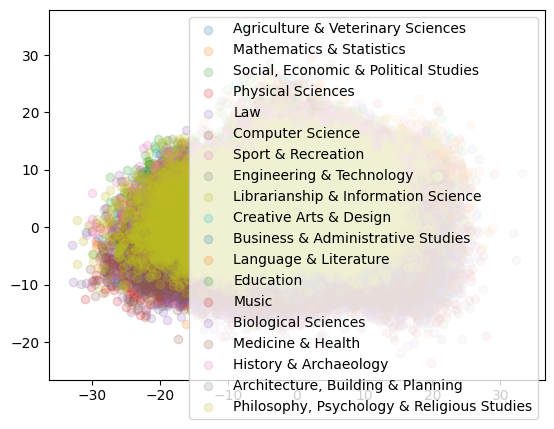

In [39]:
for label in set(labels):
    indices = np.where(labels == label)
    embeddings = dim_reduced_titles[indices]
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, alpha=0.2, label=label)
plt.legend()
plt.show()

## Classification

First splitting the dataset into a train and test set

In [18]:
dim = 50
pca = PCA(n_components = dim)
reduced_emb = pca.fit_transform(title_embeddings)

In [19]:
reduced_emb.shape

(569681, 50)

In [17]:
# from umap import UMAP

# # perform dimension reduction on the title embeddings
# reducer = UMAP(n_components=20,
#                random_state=seed,
#                transform_seed=seed)
# reduced_emb = reducer.fit_transform(title_embeddings)

In [ ]:
subjects = sorted(list(set(labels)))
label_index = [subjects.index(l) for l in labels]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(title_embeddings,
                                                    label_index,
                                                    random_state = seed)

In [18]:
len(X_train)

427260

In [19]:
len(X_test)

142421

In [ ]:
def plot_confusion_matrix(predictions, true, label_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    cm = confusion_matrix(true, predictions)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=label_names).plot(ax=ax,
                                                                             xticks_rotation="vertical")

## Decision Tree

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# training a DescisionTreeClassifier
dtree_model = DecisionTreeClassifier().fit(X_train, y_train)

# model accuracy for X_test
print(f"Accuracy: {dtree_model.score(X_test, y_test)}")

Accuracy: 0.36573258157153793


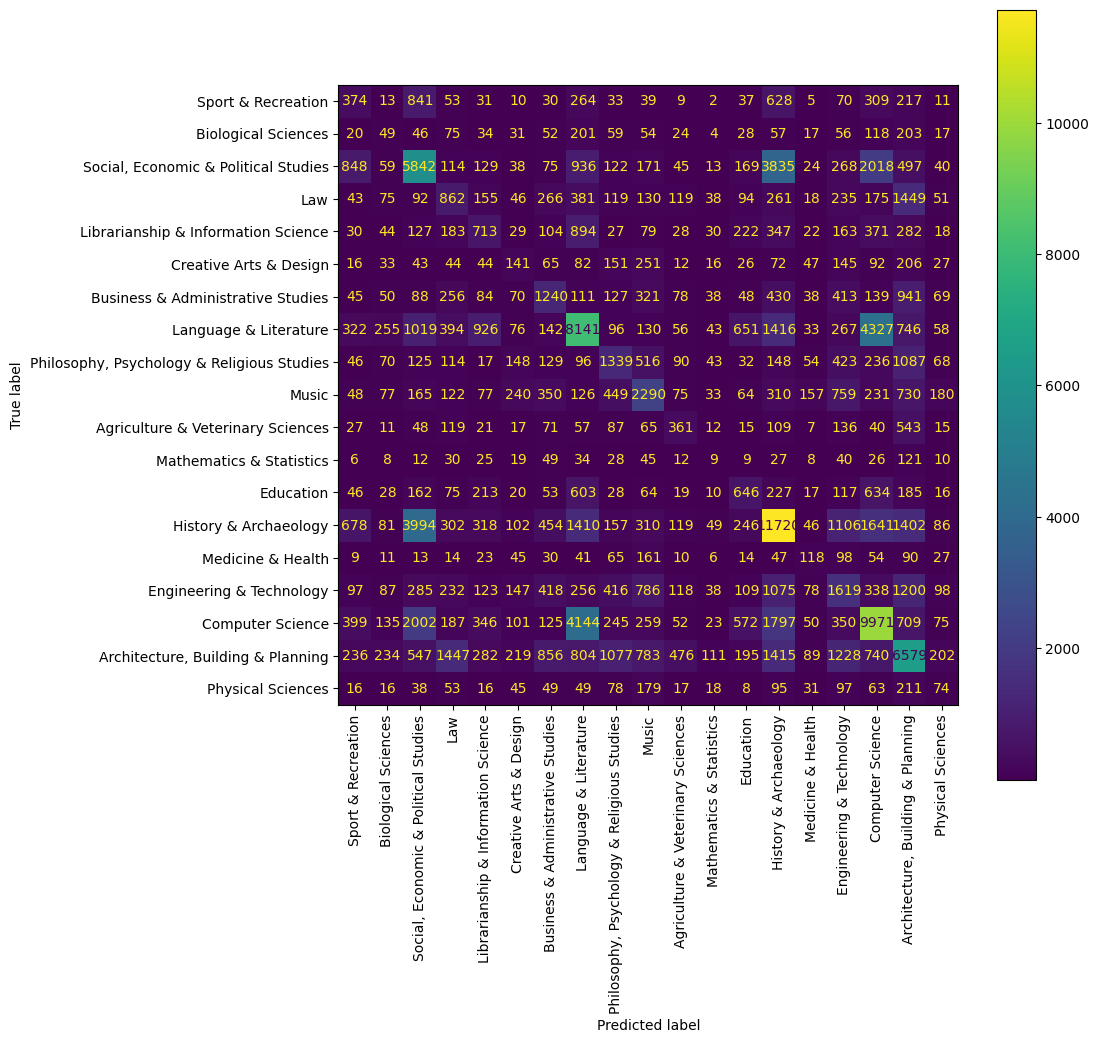

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# creating a confusion matrix
plot_confusion_matrix(predictions = dtree_model.predict(X_test),
                      true = y_test,
                      label_names = subjects)

In [20]:
dtree_predictions

array(['Physical Sciences', 'Librarianship & Information Science',
       'Social, Economic & Political Studies', ...,
       'Business & Administrative Studies', 'Biological Sciences',
       'Biological Sciences'], dtype=object)

## SVM

In [21]:
from sklearn.linear_model import SGDClassifier

# training a linear SVM classifier
svm_model_linear = SGDClassifier(loss='hinge',
                                 penalty='l2',
                                 alpha=1e-3,
                                 random_state=seed, 
                                 tol=None).fit(X_train, y_train)

# model accuracy for X_test
print(f"Accuracy: {svm_model_linear.score(X_test, y_test)}")

Accuracy: 0.6319363015285667


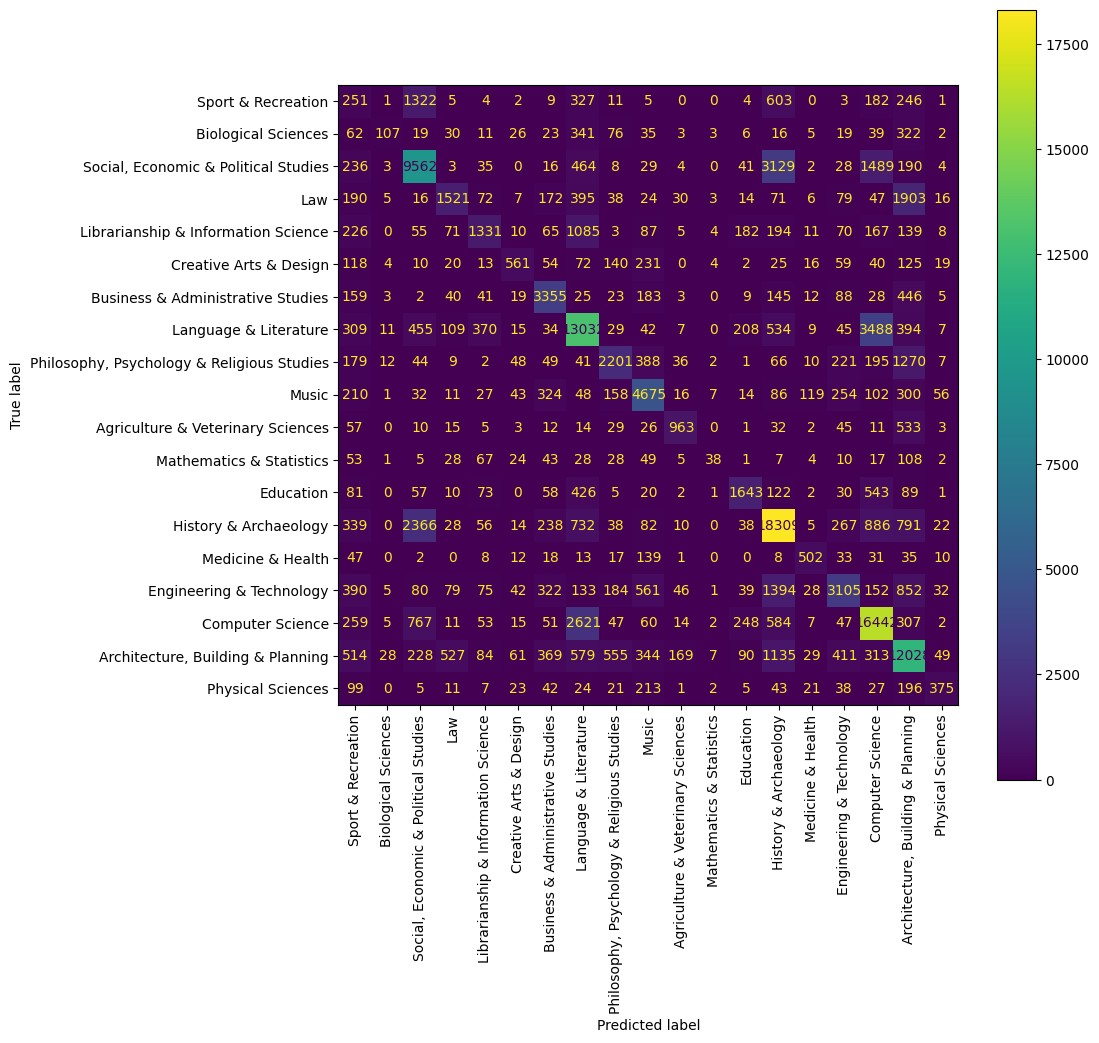

In [27]:
# creating a confusion matrix
plot_confusion_matrix(predictions = svm_model_linear.predict(X_test),
                      true = y_test,
                      label_names = subjects)

In [33]:
from sklearn.linear_model import LogisticRegression

# training a logistic regression classifier
log_reg_model_linear = LogisticRegression(penalty='l2',
                                          random_state=seed,
                                          max_iter=500,
                                          multi_class="multinomial").fit(X_train, y_train)

# model accuracy for X_test
print(f"Accuracy: {log_reg_model_linear.score(X_test, y_test)}")

/Users/rchan/opt/miniconda3/envs/ethosTDSenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6464917392800219


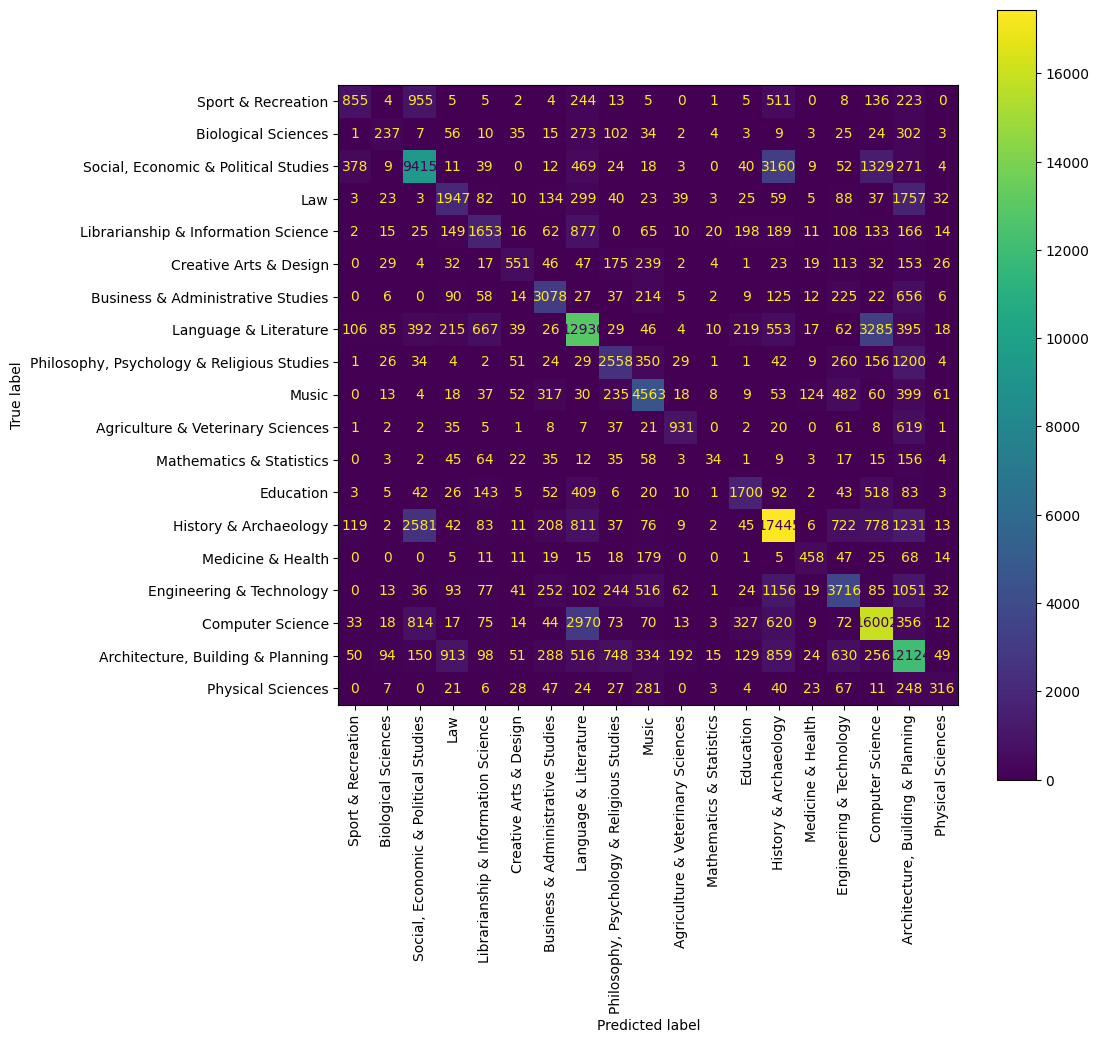

In [29]:
# creating a confusion matrix
plot_confusion_matrix(predictions = log_reg_model_linear.predict(X_test),
                      true = y_test,
                      label_names = subjects)

In [31]:
from sklearn.linear_model import LogisticRegression

# training a logistic regression classifier
log_reg_model_linear_2 = LogisticRegression(penalty='l2',
                                            random_state=seed,
                                            max_iter=200,
                                            multi_class="ovr").fit(X_train, y_train)

# model accuracy for X_test
print(f"Accuracy: {log_reg_model_linear_2.score(X_test, y_test)}")

/Users/rchan/opt/miniconda3/envs/ethosTDSenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6466111036995948


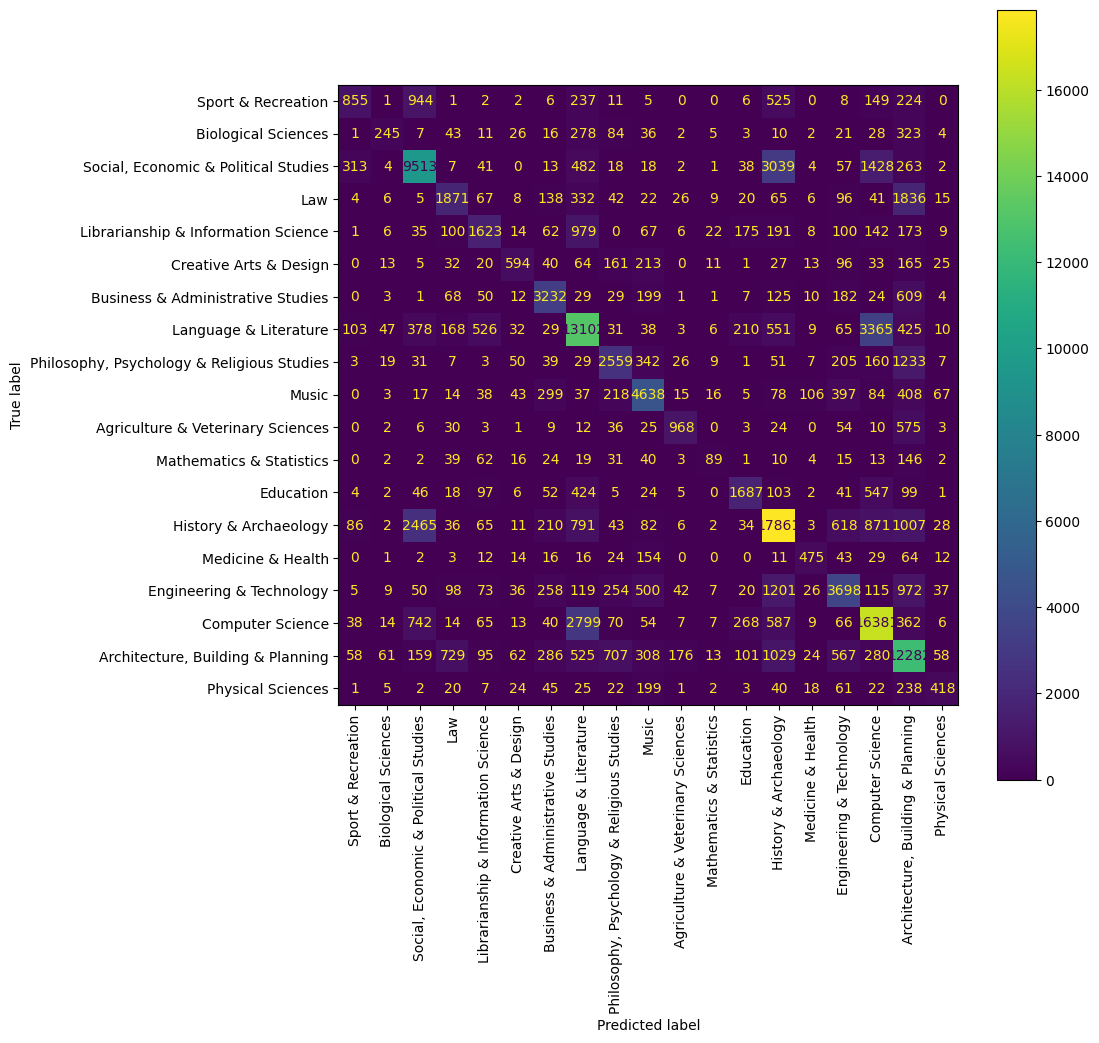

In [32]:
# creating a confusion matrix
plot_confusion_matrix(predictions = log_reg_model_linear_2.predict(X_test),
                      true = y_test,
                      label_names = subjects)

## KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# training a KNN classifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(a, y_train)
  
# model accuracy for X_test
print(f"Accuracy: {knn.score(X_test, y_test)}")

Accuracy: 0.5478546000940873


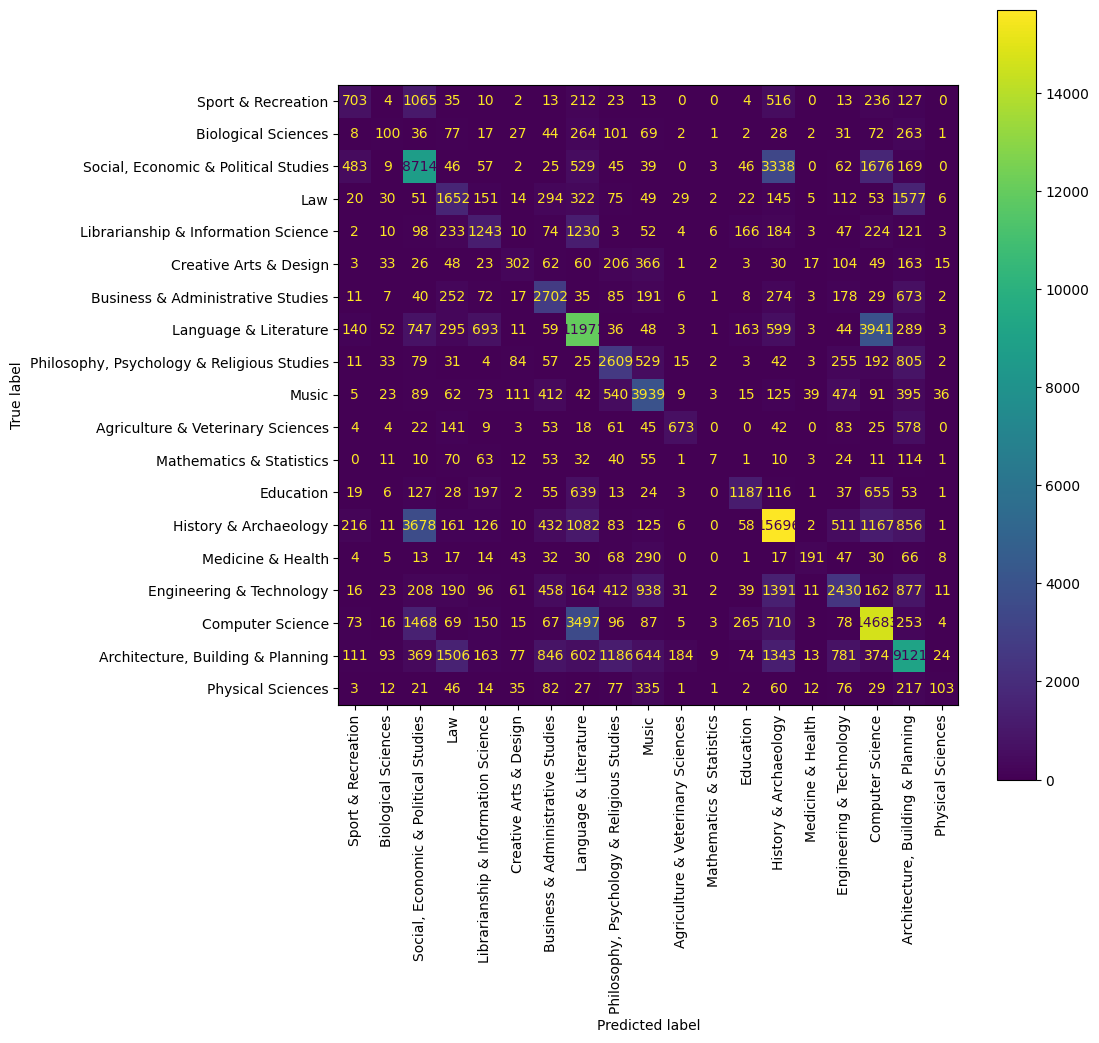

In [24]:
# creating a confusion matrix
plot_confusion_matrix(predictions = knn.predict(X_test),
                      true = y_test,
                      label_names = subjects)

## Neural Network

In [64]:
import torch
import torch.nn as nn
from pytorch_utils import KFolds, set_seed, training_pytorch, testing_pytorch, KFold_pytorch
from ffn import FeedforwardNeuralNetModel

In [58]:
input_dim = title_embeddings.shape[1]
hidden_dim = 200
output_dim = len(set(labels))
dropout_rate = 0.25
num_epochs = 1000
learning_rate = 0.0005
n_folds = 5
patience = 2

In [62]:
data_folds = KFolds(x_data = torch.tensor(title_embeddings),
                    y_data = torch.tensor(label_index),
                    n_splits = n_folds,
                    shuffle = True,
                    random_state = seed)

In [65]:
# initial model definitions
model = FeedforwardNeuralNetModel(input_dim,
                                  hidden_dim,
                                  output_dim,
                                  dropout_rate)
criterion = nn.CrossEntropyLoss() # cross-entropy for creating confident models
# criterion = nn.NLLLoss() # negative log likelihood for multi-class classification
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate)

In [ ]:
kfold_eval = KFold_pytorch(data_folds,
                           model = model,
                           criterion = criterion,
                           optimizer = optimizer,
                           num_epochs = num_epochs,
                           verbose_args = {
                               "verbose": True,
                               "verbose_epoch": 20,
                               "verbose_item": 100000
                           })

  0%|                                                                                    | 0/5 [00:00<?, ?it/s]


**************************************************
Fold: 1 / 5
**************************************************



  0%|                                                                                  | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 || Item: 0/305348 || Loss: 0.346454381942749
Epoch: 1/100 || Item: 100000/305348 || Loss: 0.4807387888431549
Epoch: 1/100 || Item: 200000/305348 || Loss: 1.2296360731124878
Epoch: 1/100 || Item: 300000/305348 || Loss: 0.6858923435211182
--------------------------------------------------
##### Epoch: 1/100 || Loss: 0.32984715700149536
--------------------------------------------------



  1%|▋                                                                      | 1/100 [04:25<7:18:52, 265.98s/it]

Epoch: 1 || Loss: 1.3622715498202682 || Accuracy: 0.5698755383491516 || F1-score: 0.34658907659066196.



 10%|███████                                                               | 10/100 [55:41<8:21:11, 334.13s/it]

Early stopping at epoch 11!



 20%|██████████████▍                                                         | 1/5 [56:02<3:44:09, 3362.46s/it]


**************************************************
Fold: 2 / 5
**************************************************



  0%|                                                                                  | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 || Item: 0/305349 || Loss: 0.6176373958587646
Epoch: 1/100 || Item: 100000/305349 || Loss: 0.02407844364643097
Epoch: 1/100 || Item: 200000/305349 || Loss: 1.5312457084655762
Epoch: 1/100 || Item: 300000/305349 || Loss: 0.953575849533081
--------------------------------------------------
##### Epoch: 1/100 || Loss: 0.19772009551525116
--------------------------------------------------



  1%|▋                                                                     | 1/100 [07:47<12:50:41, 467.08s/it]

Epoch: 1 || Loss: 1.3248899654753052 || Accuracy: 0.5695896148681641 || F1-score: 0.361163601506463.



 20%|█████████████▌                                                      | 20/100 [1:49:59<9:45:16, 438.96s/it]

Epoch: 21/100 || Item: 0/305349 || Loss: 0.8156746625900269
Epoch: 21/100 || Item: 100000/305349 || Loss: 0.15662053227424622
Epoch: 21/100 || Item: 200000/305349 || Loss: 1.3693255186080933
Epoch: 21/100 || Item: 300000/305349 || Loss: 1.230653166770935
--------------------------------------------------
##### Epoch: 21/100 || Loss: 0.2421867698431015
--------------------------------------------------



 21%|██████████████▎                                                     | 21/100 [1:54:09<8:23:19, 382.28s/it]

Epoch: 21 || Loss: 1.3693273511484807 || Accuracy: 0.6141519546508789 || F1-score: 0.494760702625846.



 29%|███████████████████▋                                                | 29/100 [2:27:20<5:19:12, 269.75s/it]

## Classification using Abstracts

In [ ]:
# only consider the records with Subject Discipline and Abstracts
df_2 = df[(df["Subject Discipline"]!=" ") & (df["Abstract"]!= " ")]

In [ ]:
len(df_2)

In [ ]:
# obtain abstract embeddings
abstract_docs = list(nlp.pipe(df_2["Abstract"], n_process=6)) 
abstract_embeddings = np.array([doc.vector for doc in docs])

# with open("spacy_abstract_embeddings.pkl", 'rb') as f:
#     embeddings = pickle.load(f)

In [ ]:
# save the embeddings for later use
with open("spacy_abstract_embeddings.pkl", 'wb') as f:
    pickle.dump(abstract_embeddings, f)

In [ ]:
subjects = sorted(list(set(labels)))
label_index = [subjects.index(l) for l in labels]
labels = np.array(df_2["Subject Discipline"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(abstract_embeddings,
                                                    label_index,
                                                    random_state = seed)

Note: be good to check if subjects here and subjects above are the same. Are there any missing subjects when looking at the abstracts?

Run the models for this dataset instead...